# Adjust nightlights based on buildings
This notebook demonstrates a process of using buteo to sharpen nightlights data.

In [24]:
!wget -nc -q https://github.com/JonathanGundorph/Nightlights/raw/main/github_bygninger_compressed.tif
!wget -nc -q https://github.com/JonathanGundorph/Nightlights/raw/main/github_nattelys.tif
!pip install buteo -q --upgrade

In [25]:
from matplotlib import pyplot as plt
import buteo as beo
import numpy as np

In [26]:
#Setup display and plotting options
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (20, 16)

# Set up initial parameters to be used later
PATH_BUILDINGS = "/content/github_bygninger_compressed.tif"
PATH_NIGHTLIGHTS = "/content/github_nattelys.tif"

EPSILON = 0.0000001 # For weighting buildings later
PIXEL_SIZE = 60 # Initial resampling to this size
FILTER_SIZE = 25 # Diameter of blur filter.
ALPHA = 0.5 # For weighting buildings later
LIGHT_MAX = 100.0
LIGHT_MIN = 0.0

print(f"Buildings will be blurred by {np.round(PIXEL_SIZE * (FILTER_SIZE /2), 2)}m")

Buildings will be blurred by 750.0m


In [27]:
# Downsample buildings resolution to 60x60m. Upsample nightlights resolution to 60x60m.
# And then turn both rasters into an array.
buildings_resampled_raster = beo.resample_raster(PATH_BUILDINGS, PIXEL_SIZE, resample_alg="average")
buildings_arr = beo.raster_to_array(buildings_resampled_raster)
buildings_arr = beo.texture_local_blur(buildings_arr, filter_size=FILTER_SIZE, spherical=True) # Takes a while the first time it is run as it is compiling C code.

nightlights_resampled_raster = beo.resample_raster(PATH_NIGHTLIGHTS, PIXEL_SIZE, resample_alg="nearest")
nightlights_arr = beo.raster_to_array(nightlights_resampled_raster)
nightlights_arr = nightlights_arr * (buildings_arr > 0.0) # mask nightlighs by buildings

buildings_arr = buildings_arr[:, :, 0]
nightlights_arr = nightlights_arr[:, :, 0]

#Print out shape
print(buildings_arr.shape, nightlights_arr.shape)

(1607, 1677) (1607, 1677)


In [28]:
# Merge buildings and nightlights
buildings_adj = (((buildings_arr / 100.0) + 1.0) ** ALPHA) - 1.0
baseline = buildings_adj * nightlights_arr

# Readjust
# TODO: Write local mean matching kernel function.
ratio = nightlights_arr.mean() / baseline.mean()
baseline = ratio * baseline

'/content/nightlights.tif'

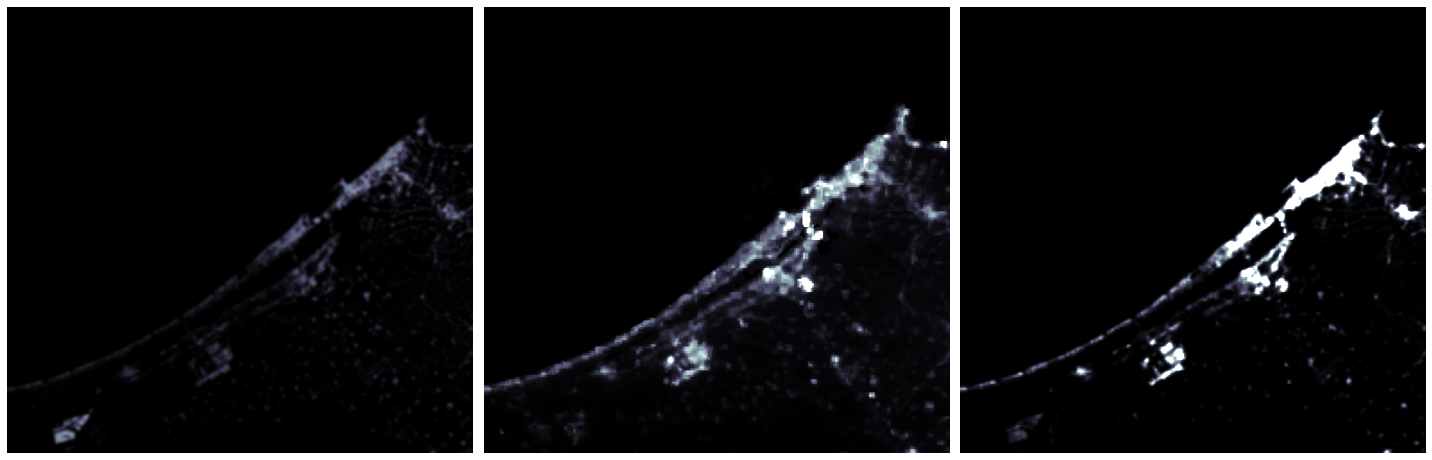

In [ ]:
# Plot the three resampled images.
fig, axes = plt.subplots(nrows=1, ncols=3)
img_left, img_center, img_right = axes

img_left.imshow(
    buildings_arr,
    vmin=0.0,
    vmax=100.0,
    interpolation="bilinear",
    cmap="bone"); img_left.axis("off")

img_center.imshow(
    nightlights_arr,
    vmin=LIGHT_MIN,
    vmax=LIGHT_MAX,
    interpolation="bilinear",
    cmap="bone"); img_center.axis("off")

img_right.imshow(
    baseline,
    vmin=LIGHT_MIN,
    vmax=LIGHT_MAX,
    interpolation="bilinear",
    cmap="bone",
); img_right.axis("off")


fig.subplots_adjust(wspace=-0.5)
plt.tight_layout()